<a href="https://colab.research.google.com/github/hpink97/loan_default_predictor/blob/main/03_ml_preprocessing_and_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load modules

In [38]:
#!pip install bayesian-optimization
#!pip install miceforest --no-cache-dir
import pandas as pd
import numpy as np 
import gc #free up memory
import matplotlib.pyplot as plt
import miceforest as mf ##forest based imputation


import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, f1_score, auc
from sklearn.preprocessing import RobustScaler,StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif


In [40]:
class Dataset:
    def __init__(self, df, target, scaler=None, trained_cols = None):
        self.df = df
        self.target = target
        self.X = self.df.drop(columns=[self.target])
        self.y = self.df[self.target]
        self.X_train = None
        self.X_test = None
        self.X_eval = None
        self.y_eval = None
        self.y_train = None
        self.y_test = None
        self.preprocessed = False
        self.scaler = scaler
        self.label_encoders = None
        self.final_X_cols = None

    ##method to pre-process the df
    def preprocess(self, impute_dict=None, imputation_kernel_iterations = 4, imputation_kernel_ntrees = 50):
       # Basic imputations
      if impute_dict is not None:
        print(f'Performing basic imputations based on {len(impute_dict)} features supplied impute_dict')
        for col, strategy in impute_dict.items():
            if strategy == 'mean':
                self.X[col].fillna(self.X[col].mean(), inplace=True)
            elif strategy == 'median':
                self.X[col].fillna(self.X[col].median(), inplace=True)
            elif isinstance(strategy, str) and strategy.startswith('percentile_'):
                percentile = float(strategy.split('_')[1])
                self.X[col].fillna(self.X[col].quantile(percentile / 100), inplace=True)
            elif isinstance(strategy, (int, float)):
                self.X[col].fillna(strategy, inplace=True)
            else:
                raise ValueError(f"Invalid imputation strategy for column '{col}'.")
      #find numeric columns
      numeric_cols = self.X.select_dtypes(include=['int64', 'float64']).columns

      ## smart impuations - decision tree based method
      count_NA = self.X.isna().sum()
      remaining_NA_cols = count_NA[count_NA>0].shape[0]
      if  remaining_NA_cols> 0:
        print(f'Performing decision-tree based imputations of {remaining_NA_cols} remaining features with missing data')
        kernal = mf.ImputationKernel(
            self.X[numeric_cols],
            random_state=42
            )
        # Run the MICE algorithm for 2 iterations
        kernal.mice(iterations=imputation_kernel_iterations,
                    n_estimators=imputation_kernel_ntrees)
        X_numeric_imputed = kernal.complete_data()
        self.X[numeric_cols] = X_numeric_imputed
      
      ##scale numeric cols
      print('Scaling numeric data')
      if self.scaler is None:
        self.scaler = StandardScaler()
        self.X[numeric_cols] = self.scaler.fit_transform(self.X[numeric_cols])
      else:
        self.X[numeric_cols] = self.scaler.transform(self.X[numeric_cols])
  
      
      # Perform label encoding for binary columns
      print('One-hot-encoding categorical vars')
      binary_cols = [col for col in self.X.columns if self.X[col].nunique() == 2]
      self.label_encoders = {}

      # Label encode binary columns
      for col in binary_cols:
          label_encoder = LabelEncoder()
          self.X[col] = label_encoder.fit_transform(self.X[col])
          # Store the label encoder for later use
          self.label_encoders[col] = label_encoder
      
      # Perform one-hot encoding for categorical columns
      categorical_cols = [col for col in self.X.columns if self.X[col].dtype == 'object' and col not in binary_cols]
      self.X = pd.get_dummies(self.X, columns=categorical_cols)

      if self.final_X_cols is not None:
        missing_cols = set(self.final_X_cols) - set(self.X.columns)
        for col in missing_cols:
          self.X[col] = 0
        self.X = self.X[self.final_X_cols]

      self.preprocessed = True
    

    def split_data(self, test_size=0.15,eval_size = 0.15, random_state=42):
        if not self.preprocessed:
            raise RuntimeError("Data has not been preprocessed. Please run the preprocess method.")
        
        X_train_eval, self.X_test, y_train_eval, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state
        )
        self.X_train, self.X_eval, self.y_train, self.y_eval = train_test_split(
            X_train_eval, y_train_eval, test_size=eval_size, random_state=random_state)

        print(f"{self.X_train.shape[0]} training samples, {self.X_eval.shape[0]} evaluation samples and {self.X_test.shape[0]} testing samples")
        print(f"{self.y_train.sum()} ({self.y_train.mean()*100:.3f}%) positives in training set")
        print(f"{self.y_eval.sum()} ({self.y_eval.mean()*100:.3f}%) positives in training set")
        print(f"{self.y_test.sum()} ({self.y_test.mean()*100:.3f})% positives in testing set")


In [47]:
class Model:
    def __init__(self, dataset_class):
        if not isinstance(dataset_class.X_train, pd.DataFrame) or not isinstance(dataset_class.X_test, pd.DataFrame):
            raise TypeError("X_train and X_test must be pandas DataFrames")
        if not isinstance(dataset_class.y_train, pd.Series) or not isinstance(dataset_class.y_test, pd.Series):
            raise TypeError("y_train and y_test must be pandas Series")
        self.X_train = dataset_class.X_train
        self.X_eval = dataset_class.X_eval
        self.X_test = dataset_class.X_test
        self.y_train = dataset_class.y_train
        self.y_eval = dataset_class.y_eval
        self.y_test = dataset_class.y_test
        self.xgboost_params = None
        self.num_features = None
        self.feature_names = dataset_class.X_train.columns
        self.selected_features = None
        self.model = None
    
    def select_features(self, num_features):
      selector = SelectKBest(score_func=mutual_info_classif, k=num_features)
      selector.fit(self.X_train, self.y_train)
      mask = selector.get_support()
      self.selected_features = self.feature_names[mask]
      self.X_train = self.X_train[self.selected_features]
      self.X_eval = self.X_eval[self.selected_features]
      self.X_test = self.X_test[self.selected_features]
    
    def train_model(self, xgboost_params):
      self.xgboost_params = xgboost_params
      dtrain = xgb.DMatrix(self.X_train, label=self.y_train)
      deval = xgb.DMatrix(self.X_eval, label = self.y_eval)
      dtest = xgb.DMatrix(self.X_test, label=self.y_test)
      self.model = xgb.train(self.xgboost_params,
                             dtrain = dtrain, 
                             evals=[(deval, 'eval')],verbose_eval=True,
                             num_boost_round=700,early_stopping_rounds=20 )
      y_pred = self.model.predict(dtest)
      y_pred_binary = np.round(y_pred)
      roc_auc = roc_auc_score(self.y_test, y_pred)
      f1 = f1_score(self.y_test, y_pred_binary)
      return roc_auc, f1
    
    def plot_roc_auc(self):
        dtest = xgb.DMatrix(self.X_test, label=self.y_test)
        y_pred = self.model.predict(dtest)
        fpr, tpr, _ = roc_curve(self.y_test, y_pred)
        roc_auc = roc_auc_score(self.y_test, y_pred)
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    
    def plot_f1_score(self):
        dtest = xgb.DMatrix(self.X_test, label=self.y_test)
        y_pred = self.model.predict(dtest)
        y_pred_binary = np.round(y_pred)
        f1 = f1_score(self.y_test, y_pred_binary)
        plt.bar(['F1 Score'], [f1])
        plt.xlabel('Metrics')
        plt.ylabel('Score')
        plt.title('F1 Score')
        plt.show()
    
    def plot_feature_importance(self, n_features =None):
      feature_importances = self.model.feature_importances_
      if n_features is None:
        n_features = len(feature_importances)

      # Get the corresponding feature names
      feature_names = self.X.columns

      # Sort feature importances and feature names in descending order
      sorted_indices = feature_importances.argsort()[::-1]
      sorted_feature_importances = feature_importances[sorted_indices]
      sorted_feature_names = feature_names[sorted_indices]

      # Create a bar plot of sorted feature importances
      plt.figure(figsize=(8, 9.5))
      plt.barh(sorted_feature_names[0:(n_features-1)][::-1], 
               sorted_feature_importances[0:(n_features-1)][::-1])
      plt.xlabel('Importance')
      plt.ylabel('Features')
      plt.title(f'Top {n_features} Features')
      plt.tight_layout()
      plt.show()


In [4]:
df= pd.read_csv('all_data_merged.csv')


In [5]:
lr_results = pd.read_csv('logistic_regression_results.csv')
important_features = lr_results.feature[lr_results.deviance_reduction >0.25]
less_relavent_features = lr_results.feature[lr_results.deviance_reduction <= 0.25]

In [6]:
impute_dict = {feature: 'median' for feature in less_relavent_features}
impute_dict['own_car_age'] = 'percentile_95'

In [43]:
data = Dataset(df, target = 'target')
data.preprocess(impute_dict=impute_dict,
                imputation_kernel_iterations=3, imputation_kernel_ntrees=40)

Performing basic imputations based on 114 features supplied impute_dict
Performing decision-tree based imputations of 10 remaining features with missing data
Scaling numeric data
One-hot-encoding categorical vars


In [44]:
data.split_data()
data.X_train.head(20)

222176 training samples, 39208 evaluation samples and 46127 testing samples
17815 (8.018%) positives in training set
3293 (8.399%) positives in training set
3717 (8.058)% positives in testing set


,sk_id_curr,name_contract_type,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,...,"wallsmaterial_mode_Stone, brick",wallsmaterial_mode_Wooden,wallsmaterial_mode_other,emergencystate_mode_No,emergencystate_mode_Yes,emergencystate_mode_other,age_group_30-45,age_group_45-60,age_group_60+,age_group_under 30
21614,-1.488496,0,0,1,-0.577538,0.047242,1.754016,0.771212,2.075888,-1.361128,...,0,0,1,0,0,1,1,0,0,0
209797,0.631905,0,0,0,-0.577538,-0.370264,-0.370260,-0.376652,-0.238644,0.714822,...,0,0,1,0,0,1,1,0,0,0
17976,-1.529492,0,1,1,-0.577538,-0.332309,-1.171895,-1.005696,-1.152275,-0.085250,...,0,0,0,1,0,0,0,0,1,0
282543,1.450496,0,1,1,-0.577538,-0.142533,-0.343282,-0.379136,-0.579733,-1.059998,...,0,0,1,0,0,1,0,0,0,1
52206,-1.145301,0,0,0,-0.577538,0.237017,0.032000,0.496122,0.078082,-0.785331,...,0,1,0,1,0,0,1,0,0,0
152195,-0.017302,0,0,1,-0.577538,-0.142533,1.633267,0.513509,0.979531,-0.994422,...,0,0,1,0,0,1,1,0,0,0
70364,-0.939367,1,0,0,-0.577538,-0.370264,-1.041084,-1.249427,-0.969549,-0.127762,...,0,0,1,1,0,0,0,0,0,1
11643,-1.601474,1,0,0,-0.577538,-0.408219,-0.985182,-1.171805,-0.908640,-0.044979,...,1,0,0,1,0,0,0,0,0,1
45591,-1.219773,0,0,1,-0.577538,0.426792,2.424840,2.165912,2.806793,0.845396,...,0,0,0,1,0,0,0,0,1,0
93535,-0.676763,0,0,0,-0.577538,-0.142533,0.842947,1.578784,0.735896,0.845396,...,0,0,0,1,0,0,1,0,0,0


In [45]:
model = Model(dataset_class=data)
model.select_features(num_features=int(data.X_train.shape[1]*0.75))
print(f"data has {data.X_train.shape[1]} features, moodel contains {model.X_train.shape[1]} features")

data has 302 features, moodel contains 226 features


In [46]:
xgb_params = {
    'max_depth': 9,
    'learning_rate': 0.01,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': 15,
    'subsample':0.6,
    'colsample_bytree':0.5
}
model.train_model(xgb_params)


ValueError: ignored

In [35]:
roc_auc

0.7362693561393441

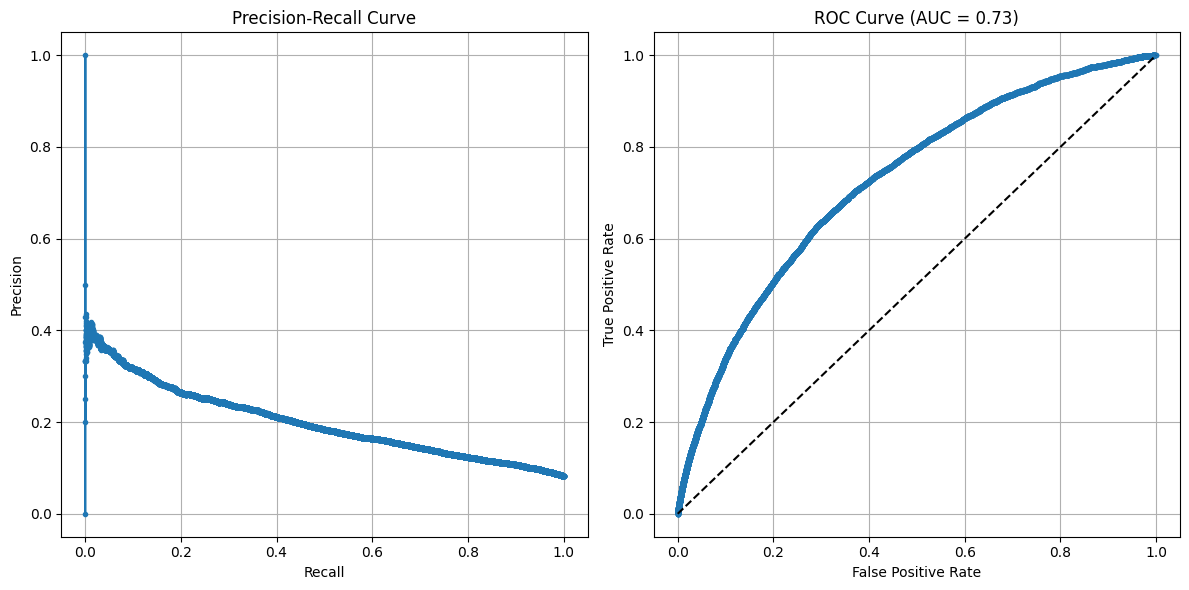

Precision: 0.0814
Recall: 1.0000
F1 Score: 0.2536
ROC-AUC: 0.7252


In [28]:
def evaluate_performance(model, X, y_true):
    """
    Evaluate model performance for binary classification and plot visualizations.

    Parameters:
        model: Trained binary classification model.
        X (array-like): Input features.
        y_true (array-like): True binary labels.
    """
    # Predict probabilities for the positive class
    y_pred_prob = model.predict_proba(X)[:, 1]

    # Compute precision, recall, and thresholds
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_prob)

    # Compute ROC curve and AUC
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_prob)
    ##calculate best threshold 
    j_stat = tpr - fpr
    index_for_best_threshold = np.argmax(j_stat)
    best_threshold = thresholds_roc[index_for_best_threshold]
    y_pred = np.where(y_pred_prob >= best_threshold, 1, 0)



    roc_auc = roc_auc_score(y_true, y_pred_prob)

    # Compute F1 score
    
    f1 = f1_score(y_true, y_pred)

    # Compute confusion matrix
    #cm = confusion_matrix(y_true, y_pred)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Precision-Recall curve
    axs[0].plot(recall, precision, marker='.')
    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[0].set_title('Precision-Recall Curve')
    axs[0].grid(True)

    # Plot ROC curve
    axs[1].plot(fpr, tpr, marker='.')
    axs[1].plot([0, 1], [0, 1], 'k--')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('ROC Curve (AUC = {:.2f})'.format(roc_auc))
    axs[1].grid(True)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print performance metrics
    #print(cm)
    print('Precision: {:.4f}'.format(precision[1]))
    print('Recall: {:.4f}'.format(recall[1]))
    print('F1 Score: {:.4f}'.format(f1))
    print('ROC-AUC: {:.4f}'.format(roc_auc))


evaluate_performance(rf_classifier, X_test, y_test)

In [31]:


selector = SelectKBest(mutual_info_classif, k=int(X_train.shape[1]*0.33))
X_reduced = selector.fit_transform(X_train, y_train)
X_reduced.shape



(230633, 101)

In [35]:
cols = selector.get_support(indices=True)
selected_columns = X.iloc[:,cols].columns.tolist()
X_train_reduced = X_train[selected_columns]



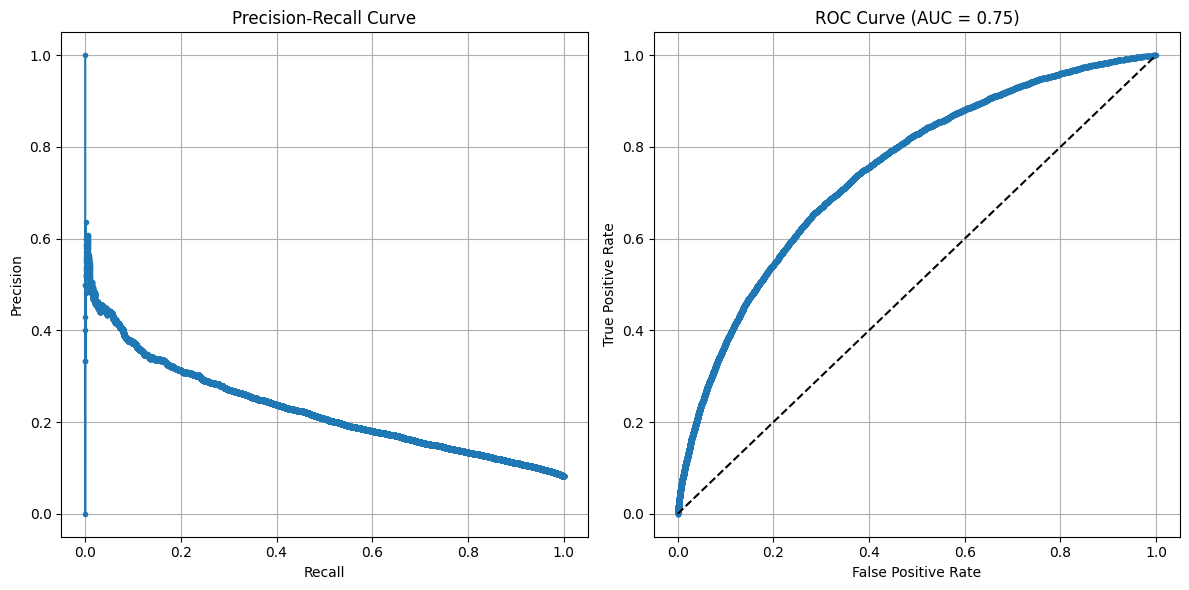

Precision: 0.0814
Recall: 1.0000
F1 Score: 0.2694
ROC-AUC: 0.7474


In [36]:
xgb_classifier = xgb.XGBClassifier(
        n_estimators=450,
        scale_pos_weight=12,
        learning_rate=0.01,
        max_depth=12,
        subsample=0.5,
        colsample_bytree=0.5,
        random_state=42
    )
xgb_classifier.fit(X_train_reduced, y_train)
evaluate_performance(xgb_classifier, X_test[selected_columns], y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


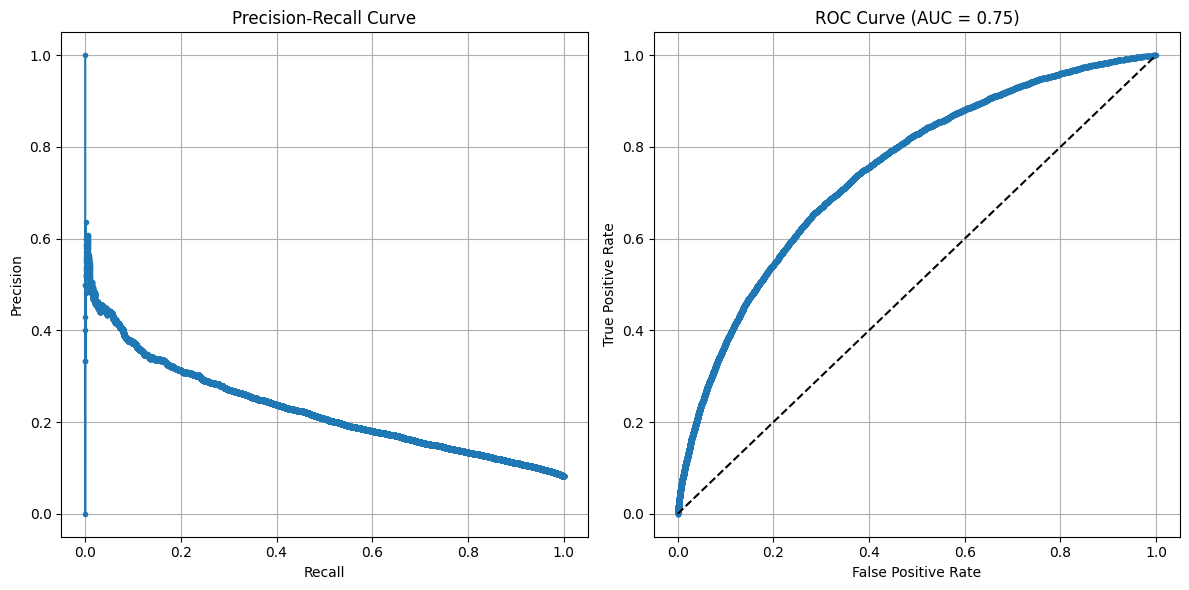

Precision: 0.0814
Recall: 1.0000
F1 Score: 0.2694
ROC-AUC: 0.7474


In [44]:
import lightgbm as lgb
# Create a LightGBM dataset
train_data = lgb.Dataset(X_train_reduced, label=y_train)

# Set the parameters for the LightGBM model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the LightGBM model
model = lgb.train(params, train_data, num_boost_round=100)
evaluate_performance(xgb_classifier, X_test[selected_columns], y_test)

In [39]:
selector2 = SelectKBest(mutual_info_classif, k=int(X_train.shape[1]*0.15))
X_reduced2 = selector2.fit_transform(X_train, y_train)
X_reduced2.shape


(230633, 46)

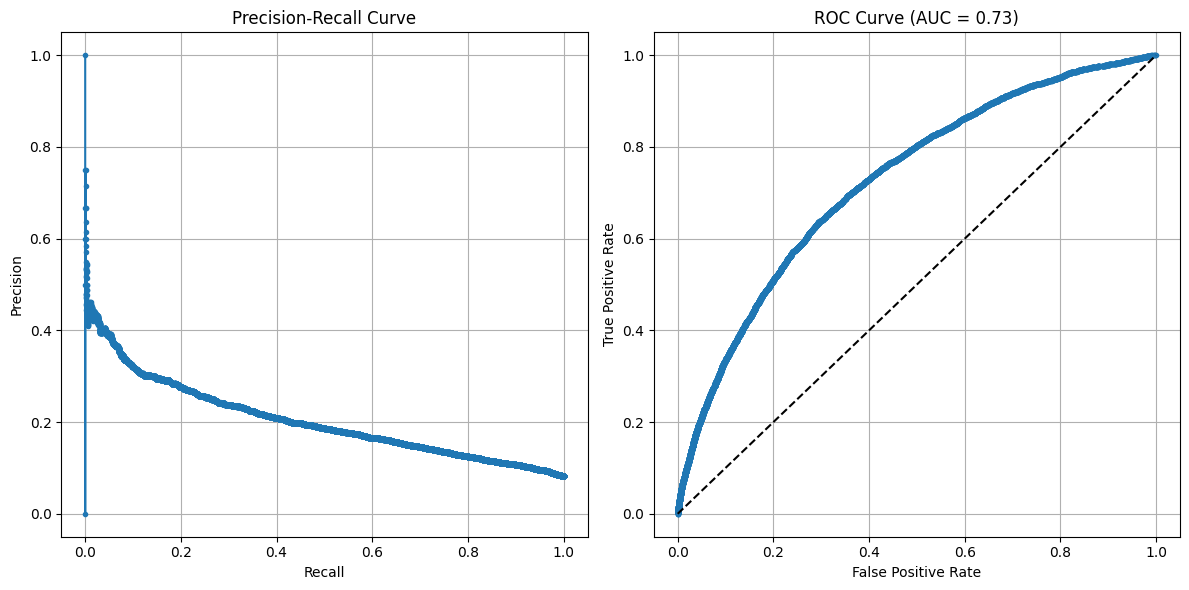

Precision: 0.0814
Recall: 1.0000
F1 Score: 0.2565
ROC-AUC: 0.7273


In [43]:
cols2 = selector2.get_support(indices=True)
selected_columns2 = X.iloc[:,cols2].columns.tolist()
X_train_reduced2 = X_train[selected_columns2]
xgb_classifier2 = xgb.XGBClassifier(
        n_estimators=450,
        scale_pos_weight=12,
        learning_rate=0.01,
        max_depth=12,
        subsample=0.5,
        colsample_bytree=0.5,
        random_state=42
    )
xgb_classifier2.fit(X_train_reduced2, y_train)
evaluate_performance(xgb_classifier2, X_test[selected_columns2], y_test)

In [42]:
X_train_reduced2.shape

(230633, 46)

In [29]:
# Define the objective function for Bayesian optimization
def xgb_objective(n_estimators, gamma, scale_pos_weight,colsample_bynode,
                  learning_rate, max_depth, subsample, colsample_bytree):
    # Convert hyperparameters to appropriate types
    learning_rate = float(learning_rate)
    max_depth = int(max_depth)
    subsample = max(min(float(subsample), 1), 0)
    colsample_bytree = max(min(float(colsample_bytree), 1), 0)
    colsample_bynode = max(min(float(colsample_bytree), 1), 0)



    # Create the XGBClassifier model with the specified hyperparameters
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        gamma = gamma,
        scale_pos_weight=scale_pos_weight,
        colsample_bynode=colsample_bynode,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )

    # Perform cross-validation and calculate the ROC AUC score
    roc_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()

    # Return the negative ROC AUC score (Bayesian optimization minimizes the objective function)
    return -roc_auc

# Define the parameter ranges for Bayesian optimization
pbounds = {
    'n_estimators':(100, 1250),
    'gamma':(0.2, 1),
    'scale_pos_weight':(1,50),
    'colsample_bynode' : (0.3,1),
    'learning_rate': (0.001, 0.1),
    'max_depth': (3, 14),
    'subsample': (0.25, 1),
    'colsample_bytree': (0.25, 1)
}

# Perform Bayesian optimization
optimizer = BayesianOptimization(
    f=xgb_objective,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)
optimizer.maximize(init_points=10, n_iter=30)

# Get the best hyperparameters and maximum ROC AUC score
best_params = optimizer.max['params']
best_score = -optimizer.max['target']




|   iter    |  target   | colsam... | colsam... |   gamma   | learni... | max_depth | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------


ValueError: ignored

In [ ]:
# Train the final XGBClassifier model with the best hyperparameters
best_model = xgb.XGBClassifier(
    
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)
best_model.fit(X, y)